<a href="https://colab.research.google.com/github/wilselby/diy_driverless_car_ROS/blob/ml-model/rover_ml/utils/Image_Regression_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setup

##Set Flag for Local or Hosted Runtime

In [0]:
local = 0

## Confirm TensorFlow can see the GPU 

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [2]:
if not local:
  import tensorflow as tf
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Import Google Drive

In [3]:
if not local:
  # Load the Drive helper and mount
  from google.colab import drive

  # This will prompt for authorization.
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Dependencies

In [4]:
if not local:
  import os
  import csv
  import cv2
  import numpy as np
  import matplotlib.pyplot as plt

  import tensorflow as tf
  tf.logging.set_verbosity(tf.logging.ERROR)

  from keras import backend as K
  from keras.models import Model, Sequential
  from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Lambda, Cropping2D
  from keras.layers.convolutional import Convolution2D
  from keras.layers.core import Flatten, Dense, Dropout, SpatialDropout2D
  from keras.optimizers import Adam
  from keras.callbacks import ModelCheckpoint, TensorBoard
  from keras.preprocessing.image import ImageDataGenerator

  import sklearn
  from sklearn.model_selection import train_test_split
  import pandas as pd

  # Improve progress bar display
  import tqdm
  import tqdm.auto
  tqdm.tqdm = tqdm.auto.tqdm

  print(tf.__version__)
else:
  import os
  import csv
  import cv2
  import numpy as np
  import matplotlib.pyplot as plt
  import tensorflow as tf
  from keras import backend as K
  from keras.models import Model, Sequential
  from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Lambda, Cropping2D
  from keras.layers.convolutional import Convolution2D
  from keras.layers.core import Flatten, Dense, Dropout, SpatialDropout2D
  from keras.optimizers import Adam
  from keras.callbacks import ModelCheckpoint
  import sklearn
  from sklearn.model_selection import train_test_split
  import pandas as pd

Using TensorFlow backend.


1.14.0


## Setup Tensorboard

In [5]:
if not local:
  # Launch Tensorboard
  # TODO https://www.tensorflow.org/tensorboard/r2/get_started

  from tensorboardcolab import *

  tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://359cc1b1.ngrok.io


# Load Dataset

## Extract Dataset

In [6]:
if not local:
  path = '/content/drive/My Drive/research/diy_driverless_car_ROS/rover_ml/output'
  data_set = 'office_delay_offset'
  tar_file = data_set + ".tar.gz"

  os.chdir(path)

  # Unzip the .tgz file
  # x for extract
  # -v for verbose 
  # -z for gnuzip
  # -f for file (should come at last just before file name)
  # -C to extract the zipped contents to a different directory
  !if [ -d $data_set ]; then echo 'Directory Exists'; else tar -xvzf $tar_file ; fi
else:
  path = '/content/drive/My Drive/research/diy_driverless_car_ROS/rover_ml/output'
  data_set = 'office_2'
  tar_file = data_set + ".tar.gz"


Directory Exists


## Parse CSV File

In [7]:
# Define path to csv file
if not local:
  csv_path = data_set + '/interpolated.csv'
else:
  csv_path = path + '/' + data_set + '/interpolated.csv'

# Load the CSV file into a pandas dataframe
df = pd.read_csv(csv_path, sep=",")

# Print the dimensions
print("Dataset Dimensions:")
print(df.shape)

# Print the first 5 lines of the dataframe for review
print("\nDataset Summary:")
df.head(5)
  

Dataset Dimensions:
(3817, 8)

Dataset Summary:


,index,timestamp,width,height,frame_id,filename,angle,speed
0,2019-06-01 19:30:34.932834053,1559417434932834053,320,240,openmv_cam,center/1559417435032834053.jpg,0.000000,0.000000
1,2019-06-01 19:30:35.043002986,1559417435043002986,320,240,openmv_cam,center/1559417435143002986.jpg,1.491693,0.098568
2,2019-06-01 19:30:35.149844074,1559417435149844074,320,240,openmv_cam,center/1559417435249844074.jpg,1.507192,0.098568
3,2019-06-01 19:30:35.252380037,1559417435252380037,320,240,openmv_cam,center/1559417435352380037.jpg,1.491543,0.099568
4,2019-06-01 19:30:35.361442947,1559417435361442947,320,240,openmv_cam,center/1559417435461442947.jpg,0.904426,0.101248


# Clean and Pre-process the Dataset

## Remove Unneccessary Columns

In [8]:
# Remove 'index' and 'frame_id' columns 
df.drop(['index','frame_id'],axis=1,inplace=True)

# Verify new dataframe dimensions
print("Dataset Dimensions:")
print(df.shape)

# Print the first 5 lines of the new dataframe for review
print("\nDataset Summary:")
print(df.head(5))

Dataset Dimensions:
(3817, 6)

Dataset Summary:
             timestamp  width  ...     angle     speed
0  1559417434932834053    320  ...  0.000000  0.000000
1  1559417435043002986    320  ...  1.491693  0.098568
2  1559417435149844074    320  ...  1.507192  0.098568
3  1559417435252380037    320  ...  1.491543  0.099568
4  1559417435361442947    320  ...  0.904426  0.101248

[5 rows x 6 columns]


## Detect Missing Data

In [9]:
# Detect Missing Values
print("Any Missing Values?: {}".format(df.isnull().values.any()))

# Total Sum
print("\nTotal Number of Missing Values: {}".format(df.isnull().sum().sum()))

# Sum Per Column
print("\nTotal Number of Missing Values per Column:")
print(df.isnull().sum())

Any Missing Values?: False

Total Number of Missing Values: 0

Total Number of Missing Values per Column:
timestamp    0
width        0
height       0
filename     0
angle        0
speed        0
dtype: int64


## Remove Zero Throttle Values

In [10]:
# Determine if any throttle values are zeroes
print("Any 0 throttle values?: {}".format(df['speed'].eq(0).any()))

# Determine number of 0 throttle values:
print("\nNumber of 0 throttle values: {}".format(df['speed'].eq(0).sum()))

# Remove rows with 0 throttle values
if df['speed'].eq(0).any():
  df = df.query('speed != 0')
  
  # Reset the index
  df.reset_index(inplace=True)
  
# Verify new dataframe dimensions
print("\nNew Dataset Dimensions:")
print(df.shape)

Any 0 throttle values?: True

Number of 0 throttle values: 1

New Dataset Dimensions:
(3816, 7)


## View Label Statistics

In [11]:
# Steering Command Statistics
print("\nSteering Command Statistics:")
print(df['angle'].describe())

print("\nThrottle Command Statistics:")
# Throttle Command Statistics
print(df['speed'].describe())


Steering Command Statistics:
count    3816.000000
mean        0.826578
std         0.932100
min        -1.532910
25%         0.111171
50%         1.373665
75%         1.481405
max         1.541583
Name: angle, dtype: float64

Throttle Command Statistics:
count    3816.000000
mean        0.112546
std         0.013608
min         0.000379
25%         0.105663
50%         0.112759
75%         0.120494
max         0.150000
Name: speed, dtype: float64


## View Histogram of Steering Commands

In [12]:
num_bins = 25
hist, bins = np.histogram(df['angle'], num_bins)
print(bins)

[-1.53290974 -1.40993005 -1.28695035 -1.16397066 -1.04099097 -0.91801127
 -0.79503158 -0.67205188 -0.54907219 -0.4260925  -0.3031128  -0.18013311
 -0.05715342  0.06582628  0.18880597  0.31178566  0.43476536  0.55774505
  0.68072474  0.80370444  0.92668413  1.04966382  1.17264352  1.29562321
  1.4186029   1.5415826 ]


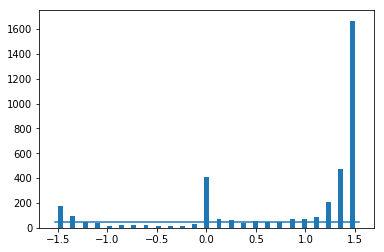

In [13]:
num_bins = 25
samples_per_bin = 50
hist, bins = np.histogram(df['angle'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df['angle']), np.max(df['angle'])), (samples_per_bin, samples_per_bin))

In [0]:
# Normalize the histogram
#print('total data:', len(df))
#remove_list = []
#for j in range(num_bins):
#  list_ = []
#  for i in range(len(df['angle'])):
#    if df.loc[i,'angle'] >= bins[j] and df.loc[i,'angle'] <= bins[j+1]:
#      list_.append(i)
#  list_ = shuffle(list_)
#  list_ = list_[samples_per_bin:]
#  remove_list.extend(list_)
 
#print('removed:', len(remove_list))
#data.drop(data.index[remove_list], inplace=True)
#print('remaining:', len(data))
 
#hist, _ = np.histogram(data['steering'], (num_bins))
#plt.bar(center, hist, width=0.05)
#plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

## View a Sample Image

/content/drive/My Drive/research/diy_driverless_car_ROS/rover_ml/output/office_delay_offset/center/1559417446016623973.jpg


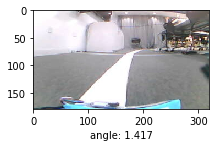

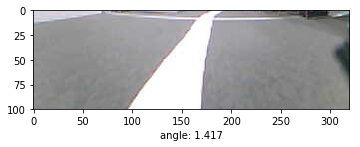

In [30]:
# Crop values
y = 100
h = 100
x = 0
w = 320

image[y:y+h, x:x+w]
# View a Single Image 
num = 105
img_name = path + '/' + data_set + '/' + df.loc[num,'filename']
angle = df.loc[num,'angle']
print(img_name)
center_image = cv2.imread(img_name)
crop_img = center_image[y:y+h, x:x+w]
center_image_mod = cv2.resize(center_image, (320,180)) #resize from 720x1280 to 180x320

plt.subplot(2,1,1)
plt.imshow(center_image_mod)
plt.grid(False)
plt.xlabel('angle: {:.4}'.format(angle))
plt.show() 

plt.subplot(2,1,2)
plt.imshow(crop_img)
plt.grid(False)
plt.xlabel('angle: {:.4}'.format(angle))
plt.show() 

## View Multiple Images

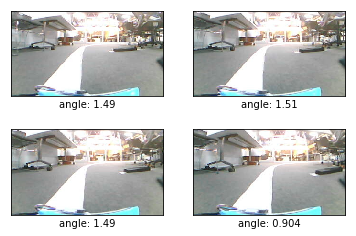

In [20]:
# Number of Images to Display
num_images = 4

# Display the images
i = 0
for i in range (0,num_images):
    image_path = df.loc[i,'filename']
    angle = df.loc[i,'angle']
    img_name = path + '/' + data_set + '/' + image_path
    image = cv2.imread(img_name)
    image = cv2.resize(image, (320,180))
    plt.subplot(num_images/2,num_images/2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel('angle: {:.3}'.format(angle))
    i += 1

## Load the Images

In [0]:
# Define image loading function
def load_images(dataframe):
  
  # initialize images array
  images = []
  
  for i in df.index.values:
    name = path + '/' + data_set + '/' + dataframe.loc[i,'filename'] 
    center_image = cv2.imread(name)
    crop_img = center_image[100:200, 0:320]
    center_image = cv2.resize(crop_img, (320,180))
    images.append(center_image)
    
  return np.array(images)
  
# Load images   
images = load_images(df) 

# Normalize image values
images = images / 255.0

# Split the Dataset

## Create the feature set

In [32]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

print("Number of training samples: {}".format(trainAttrX.shape[0]))
print("Number of validation samples: {}".format(testAttrX.shape[0]))


Number of training samples: 2862
Number of validation samples: 954


## Create the label set

In [0]:
trainY = trainAttrX["angle"] 
testY = testAttrX["angle"]

## Define a Batch Generator

In [0]:
def csv_image_generator(dataframe, batch_size, mode="train", aug=None):
  
  num_samples = dataframe.shape[0]
  
  # loop indefinitely
  while True:
    
    for offset in range(0, num_samples, batch_size):
      batch_samples = dataframe[offset:offset+batch_size]
    
      # initialize our batches of images and labels
      #print("\nLoaded batch {0}\n".format(1+(offset/batch_size)))
      images = []
      print("Init {}".format(type(images)))
      labels = []
      index = 0
      
      for index in range(0,batch_samples.shape[0]):
        if batch_samples.loc[offset,'filename'] != "filename":
    
          name = path + '/' + data_set + '/' + dataframe.loc[offset,'filename']
          center_image = cv2.imread(name)
          center_image = cv2.resize(center_image, (320,180))
          label = dataframe.loc[offset,'angle']
          print("Loop {}".format(type(images)))
          images.append(center_image)
          labels.append(label)
          
          index += 1
      
          # if the data augmentation object is not None, apply it
          if aug is not None:
            (images, labels) = next(aug.flow(np.array(images), labels, batch_size=batch_size))
          print("Aug {}".format(type(images)))
 
      # yield the batch to the calling function
      yield (np.array(images), labels)
        


## Define an Image Augmentation Data Generator

In [0]:
# Construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	vertical_flip=True, fill_mode="nearest")

## Initialize Data Generators

In [0]:
# Define a batch size
batch_size = 32

# initialize both the training and testing image generators
trainGen = csv_image_generator(df, batch_size, mode="train", aug=aug)
testGen = csv_image_generator(df, batch_size, mode="train", aug=None)

# Train the Model

## Preprocess the Input Image

In [0]:
# Initialize the model
model = Sequential()

# trim image to only see section with road
# (top_crop, bottom_crop), (left_crop, right_crop)
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(180,320,3)))

## Build the Model

In [38]:
# Nvidia model
model.add(Convolution2D(24, (5, 5), activation="relu", name="conv_1", strides=(2, 2)))
model.add(Convolution2D(36, (5, 5), activation="relu", name="conv_2", strides=(2, 2)))
model.add(Convolution2D(48, (5, 5), activation="relu", name="conv_3", strides=(2, 2)))
model.add(SpatialDropout2D(.5, dim_ordering='default'))

model.add(Convolution2D(64, (3, 3), activation="relu", name="conv_4", strides=(1, 1)))
model.add(Convolution2D(64, (3, 3), activation="relu", name="conv_5", strides=(1, 1)))

model.add(Flatten())

model.add(Dense(1164))
model.add(Dropout(.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse','mape'])

# Print model sumamry
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `SpatialDropout2D` call to the Keras 2 API: `SpatialDropout2D(0.5, data_format=None)`
  after removing the cwd from sys.path.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 110, 320, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 53, 158, 24)       1824      
_________________________________________________________________
conv_2 (Conv2D)              (None, 25, 77, 36)        21636     
_________________________________________________________________
conv_3 (Conv2D)              (None, 11, 37, 48)        43248     
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 11, 37, 48)        0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 9, 35, 64)         27712     
_________________________________________________________________
conv_5 (Conv2D)              (None, 7, 33, 64)        

## Setup Checkpoints

In [39]:
# checkpoint
model_path = data_set + '/model'

!if [ -d $model_path ]; then echo 'Directory Exists'; else mkdir $model_path; fi


filepath = path + '/' + model_path + "/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)

#model.load_weights(model_path = '/')

Directory Exists


## Setup Tensorboard

In [0]:
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True)

## Training

In [41]:
# Define number of epochs
n_epoch = 35

# Define callbacks
callbacks_list = [TensorBoardColabCallback(tbc)]

# Fit the model
#history_object = model.fit_generator(train_generator, steps_per_epoch=(len(train_samples) / batch_size_value), validation_data=validation_generator, validation_steps=(len(validation_samples)/batch_size_value), callbacks=callbacks_list, epochs=n_epoch)
#history_object = model.fit_generator(
#	trainGen,
#	steps_per_epoch=trainAttrX.shape[0] // batch_size,
#	validation_data=testGen,
#	validation_steps=testAttrX.shape[0] // batch_size,
#  callbacks=callbacks_list,
#	epochs=n_epoch)

# Fit the model
history_object = model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY), callbacks=callbacks_list, epochs=n_epoch, batch_size=batch_size)

Train on 2862 samples, validate on 954 samples
Epoch 1/35
2862/2862 [==============================] - 15s 5ms/step - loss: 1.3029 - mean_squared_error: 1.3029 - mean_absolute_percentage_error: 35843251.3986 - val_loss: 1.0658 - val_mean_squared_error: 1.0658 - val_mean_absolute_percentage_error: 39151797.8904
Epoch 2/35
2862/2862 [==============================] - 10s 3ms/step - loss: 1.0673 - mean_squared_error: 1.0673 - mean_absolute_percentage_error: 50487607.2418 - val_loss: 1.0173 - val_mean_squared_error: 1.0173 - val_mean_absolute_percentage_error: 45098459.9253
Epoch 3/35
2862/2862 [==============================] - 10s 3ms/step - loss: 1.0000 - mean_squared_error: 1.0000 - mean_absolute_percentage_error: 54559039.3322 - val_loss: 0.9282 - val_mean_squared_error: 0.9282 - val_mean_absolute_percentage_error: 58688594.1152
Epoch 4/35
2862/2862 [==============================] - 10s 3ms/step - loss: 0.9603 - mean_squared_error: 0.9603 - mean_absolute_percentage_error: 57515486.17

## Save the Model

In [42]:
# Save model
model_path_full = path + '/' + model_path + '/'

model.save(model_path_full + 'model.h5')
with open(model_path_full + 'model.json', 'w') as output_json:
    output_json.write(model.to_json())

# Save TensorFlow model
tf.train.write_graph(K.get_session().graph.as_graph_def(), logdir=model_path_full, name='model.pb', as_text=False)


'/content/drive/My Drive/research/diy_driverless_car_ROS/rover_ml/output/office_delay_offset/model/model.pb'

# Evaluate the Model

In [0]:
#scores = model.evaluate(testImagesX, testY, verbose=0, batch_size=32)
#print("Loss: {}".format(scores*100))
  
#score = model.evaluate_generator(validation_generator, len(validation_samples)/batch_size_value,use_multiprocessing=True)
#print("Loss: {:.2}".format(score))

## Compute the loss

In [43]:
#TODO: Remove 0s in dataset

preds = model.predict(testImagesX)


diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

#print(diff/testY)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] mean: inf%, std: nan%


## Plot a Prediction

## Plot the Results

Generating loss chart...
Done.


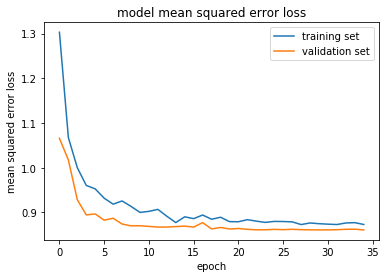

In [44]:
model_path_full = path + '/' + model_path + '/'

# Plot the training and validation loss for each epoch
print('Generating loss chart...')
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig(model_path_full + 'model.png')

# Done
print('Done.')

# References:
https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/
https://www.pyimagesearch.com/2019/01/21/regression-with-keras/
https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l04c01_image_classification_with_cnns.ipynb#scrollTo=7MqDQO0KCaWS